# Bank check OCR with OpenCV 

In [1]:
%cd bank-check-ocr

/content/bank-check-ocr


### Import Packages

In [2]:
# import the necessary packages
from skimage.segmentation import clear_border
from imutils import contours
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Extracting MICR digits and symbols with OpenCV

In [4]:
def extract_digits_and_symbols(image, charCnts, minW=5, minH=15):
	# grab the internal Python iterator for the list of character
	# contours, then  initialize the character ROI and location
	# lists, respectively
	charIter = charCnts.__iter__()
	rois = []
	locs = []

	# keep looping over the character contours until we reach the end
	# of the list
	while True:
		try:
			# grab the next character contour from the list, compute
			# its bounding box, and initialize the ROI
			c = next(charIter)
			(cX, cY, cW, cH) = cv2.boundingRect(c)
			roi = None

			# check to see if the width and height are sufficiently
			# large, indicating that we have found a digit
			if cW >= minW and cH >= minH:
				# extract the ROI
				roi = image[cY:cY + cH, cX:cX + cW]
				rois.append(roi)
				locs.append((cX, cY, cX + cW, cY + cH))

			# otherwise, we are examining one of the special symbols
			else:
				# MICR symbols include three separate parts, so we
				# need to grab the next two parts from our iterator,
				# followed by initializing the bounding box
				# coordinates for the symbol
				parts = [c, next(charIter), next(charIter)]
				(sXA, sYA, sXB, sYB) = (np.inf, np.inf, -np.inf,
					-np.inf)

				# loop over the parts
				for p in parts:
					# compute the bounding box for the part, then
					# update our bookkeeping variables
					(pX, pY, pW, pH) = cv2.boundingRect(p)
					sXA = min(sXA, pX)
					sYA = min(sYA, pY)
					sXB = max(sXB, pX + pW)
					sYB = max(sYB, pY + pH)

				# extract the ROI
				roi = image[sYA:sYB, sXA:sXB]
				rois.append(roi)
				locs.append((sXA, sYA, sXB, sYB))

		# we have reached the end of the iterator; gracefully break
		# from the loop
		except StopIteration:
			break

	# return a tuple of the ROIs and locations
	return (rois, locs)

In [5]:
args = {
	"image": "example_check.png",
	"reference": "micr_e13b_reference.png"
}

In [6]:
# initialize the list of reference character names, in the same
# order as they appear in the reference image where the digits
# their names and:
# T = Transit (delimit bank branch routing transit #)
# U = On-us (delimit customer account number)
# A = Amount (delimit transaction amount)
# D = Dash (delimit parts of numbers, such as routing or account)
charNames = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0",
	"T", "U", "A", "D"]

In [7]:
# load the reference MICR image from disk, convert it to grayscale,
# and threshold it, such that the digits appear as *white* on a
# *black* background
ref = cv2.imread(args["reference"])
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = imutils.resize(ref, width=400)
ref = cv2.threshold(ref, 0, 255, cv2.THRESH_BINARY_INV |
	cv2.THRESH_OTSU)[1]

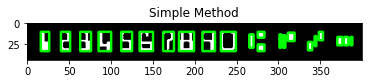

In [8]:
# find contours in the MICR image (i.e,. the outlines of the
# characters) and sort them from left to right
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[0] if imutils.is_cv2(or_better=True) else refCnts[1]
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

# create a clone of the original image so we can draw on it
clone = np.dstack([ref.copy()] * 3)

# loop over the (sorted) contours
for c in refCnts:
	# compute the bounding box of the contour and draw it on our
	# image
	(x, y, w, h) = cv2.boundingRect(c)
	cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

# show the output of applying the simple contour method
plt_imshow("Simple Method", clone)

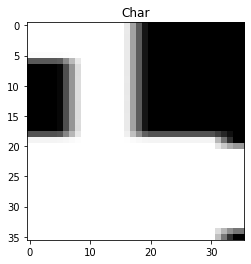

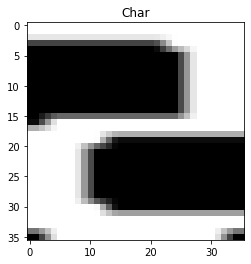

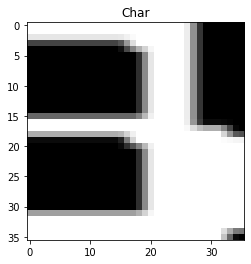

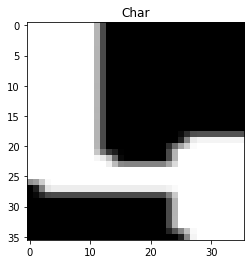

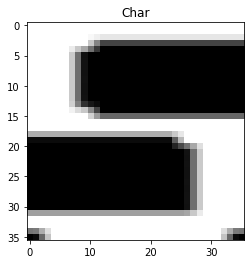

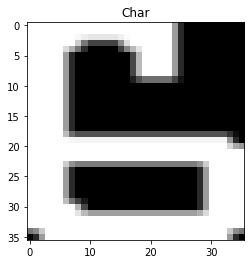

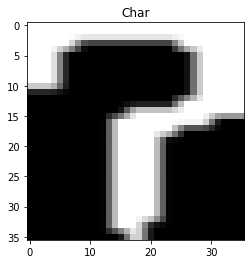

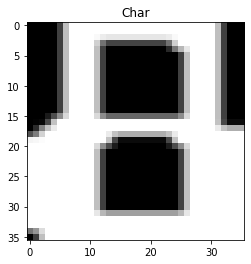

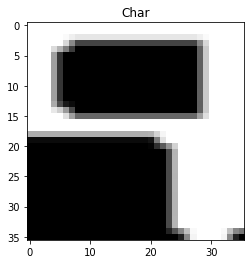

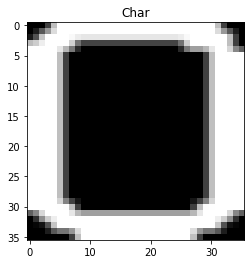

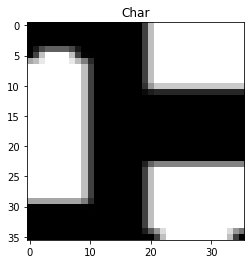

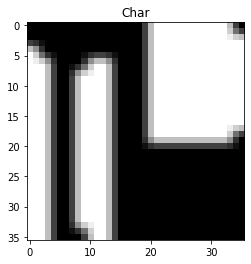

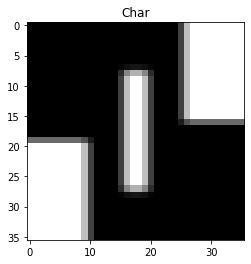

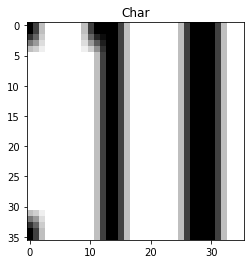

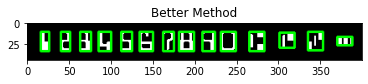

In [9]:
# extract the digits and symbols from the list of contours, then
# initialize a dictionary to map the character name to the ROI
(refROIs, refLocs) = extract_digits_and_symbols(ref, refCnts,
	minW=10, minH=20)
chars = {}

# re-initialize the clone image so we can draw on it again
clone = np.dstack([ref.copy()] * 3)

# loop over the reference ROIs and locations
for (name, roi, loc) in zip(charNames, refROIs, refLocs):
	# draw a bounding box surrounding the character on the output
	# image
	(xA, yA, xB, yB) = loc
	cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 255, 0), 2)
	
    # resize the ROI to a fixed size, then update the characters
	# dictionary, mapping the character name to the ROI
	roi = cv2.resize(roi, (36, 36)) 
	chars[name] = roi
	
    # display the character ROI to our screen
	plt_imshow("Char", roi)

# show the output of our better method
plt_imshow("Better Method", clone)